# Advanced ML Models (Task 2.2)

This notebook builds advanced machine learning models to beat the 57.4% 2.0 baseline.

**Models:**
1. **Random Forest**: Ensemble of decision trees
2. **XGBoost**: Gradient boosting with regularization
3. **Feature Selection**: Identify most important features
4. **Hyperparameter Tuning**: Optimize model performance

**Baseline Performance to Beat:**
- 2.0 System: 57.4% win rate
- Logistic Regression: 52.8% ± 3.6% accuracy
- Linear Regression: MAE 2.25%, R² 0.226

**Target:**
- Direction accuracy > 60.3% (minimum), > 63.2% (goal)
- Magnitude prediction R² > 0.30

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data and Prepare Features

In [2]:
# Load merged features
features_df = pd.read_parquet('../data/features/all_features.parquet')

print(f"Loaded features shape: {features_df.shape}")
print(f"Date range: {features_df['earnings_date'].min()} to {features_df['earnings_date'].max()}")

# Target variables
target_magnitude = 'current_abs_move_pct'
target_direction = 'current_close_move_pct'

# Clean dataset
df_clean = features_df.dropna(subset=[target_magnitude, target_direction]).copy()
df_clean['direction_binary'] = (df_clean[target_direction] > 0).astype(int)

print(f"\nClean dataset: {len(df_clean)} rows")
print(f"\nDirection distribution:")
print(f"  Up (1): {df_clean['direction_binary'].sum()} ({df_clean['direction_binary'].mean()*100:.1f}%)")
print(f"  Down (0): {(~df_clean['direction_binary'].astype(bool)).sum()} ({(1-df_clean['direction_binary'].mean())*100:.1f}%)")

Loaded features shape: (4926, 83)
Date range: 2007-07-18 00:00:00 to 2025-11-19 00:00:00

Clean dataset: 4926 rows

Direction distribution:
  Up (1): 2547 (51.7%)
  Down (0): 2379 (48.3%)


In [3]:
# Prepare features (same as baseline)
exclude_cols = ['ticker', 'earnings_date', target_magnitude, target_direction,
                'earnings_frequency', 'vix_regime', 'market_regime', 'direction_binary']

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Filter to numeric only
numeric_features = []
for col in feature_cols:
    if df_clean[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        numeric_features.append(col)

print(f"Numeric features: {len(numeric_features)}")

# Check missing values
missing_pct = (df_clean[numeric_features].isna().sum() / len(df_clean)) * 100
features_to_drop = missing_pct[missing_pct > 50].index.tolist()

print(f"\nDropping {len(features_to_drop)} features with >50% missing")

feature_cols_filtered = [c for c in numeric_features if c not in features_to_drop]
print(f"Remaining features: {len(feature_cols_filtered)}")

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_clean[feature_cols_filtered])
X_df = pd.DataFrame(X_imputed, columns=feature_cols_filtered, index=df_clean.index)

# Targets
y_magnitude = df_clean[target_magnitude]
y_direction = df_clean['direction_binary']

# Metadata
metadata = df_clean[['ticker', 'earnings_date']].copy()

print(f"\nFeature matrix: {X_df.shape}")
print(f"Missing values after imputation: {X_df.isna().sum().sum()}")

Numeric features: 71

Dropping 13 features with >50% missing
Remaining features: 58

Feature matrix: (4926, 58)
Missing values after imputation: 0


## 2. Train/Test Split (Time-Series Aware)

Use 80/20 split by date for final evaluation

In [4]:
# Sort by date and split 80/20
df_sorted = metadata.sort_values('earnings_date').reset_index(drop=True)
split_date = df_sorted['earnings_date'].quantile(0.8)

train_mask = df_sorted['earnings_date'] <= split_date
test_mask = df_sorted['earnings_date'] > split_date

# Get indices
train_idx = df_sorted[train_mask].index.tolist()
test_idx = df_sorted[test_mask].index.tolist()

# Split features and targets
X_train = X_df.loc[train_idx]
X_test = X_df.loc[test_idx]
y_train_mag = y_magnitude.loc[train_idx]
y_test_mag = y_magnitude.loc[test_idx]
y_train_dir = y_direction.loc[train_idx]
y_test_dir = y_direction.loc[test_idx]

print(f"Split date: {split_date}")
print(f"\nTraining set: {len(train_idx)} samples")
print(f"  Date range: {df_sorted.loc[train_idx, 'earnings_date'].min()} to {df_sorted.loc[train_idx, 'earnings_date'].max()}")
print(f"  Direction: {y_train_dir.mean()*100:.1f}% up")

print(f"\nTest set: {len(test_idx)} samples")
print(f"  Date range: {df_sorted.loc[test_idx, 'earnings_date'].min()} to {df_sorted.loc[test_idx, 'earnings_date'].max()}")
print(f"  Direction: {y_test_dir.mean()*100:.1f}% up")

Split date: 2025-04-24 00:00:00

Training set: 3962 samples
  Date range: 2007-07-18 00:00:00 to 2025-04-24 00:00:00
  Direction: 51.4% up

Test set: 964 samples
  Date range: 2025-04-25 00:00:00 to 2025-11-19 00:00:00
  Direction: 53.0% up


## 3. Random Forest Models

In [5]:
print("="*60)
print("RANDOM FOREST - MAGNITUDE PREDICTION")
print("="*60)

# Train Random Forest Regressor
rf_mag = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest Regressor...")
rf_mag.fit(X_train, y_train_mag)

# Predictions
y_pred_mag_train = rf_mag.predict(X_train)
y_pred_mag_test = rf_mag.predict(X_test)

# Evaluate
print("\nTraining Performance:")
print(f"  MAE:  {mean_absolute_error(y_train_mag, y_pred_mag_train):.3f}%")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_mag, y_pred_mag_train)):.3f}%")
print(f"  R²:   {r2_score(y_train_mag, y_pred_mag_train):.3f}")

print("\nTest Performance:")
print(f"  MAE:  {mean_absolute_error(y_test_mag, y_pred_mag_test):.3f}%")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_mag, y_pred_mag_test)):.3f}%")
print(f"  R²:   {r2_score(y_test_mag, y_pred_mag_test):.3f}")

# Baseline comparison
baseline_mag_mae = 2.254
baseline_mag_r2 = 0.226
test_mae = mean_absolute_error(y_test_mag, y_pred_mag_test)
test_r2 = r2_score(y_test_mag, y_pred_mag_test)

print(f"\nComparison to Baseline (Linear Regression):")
print(f"  MAE:  {test_mae:.3f}% vs {baseline_mag_mae:.3f}% baseline ({(baseline_mag_mae - test_mae)/baseline_mag_mae*100:+.1f}%)")
print(f"  R²:   {test_r2:.3f} vs {baseline_mag_r2:.3f} baseline ({(test_r2 - baseline_mag_r2)/baseline_mag_r2*100:+.1f}%)")

RANDOM FOREST - MAGNITUDE PREDICTION

Training Random Forest Regressor...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s



Training Performance:
  MAE:  1.524%
  RMSE: 2.435%
  R²:   0.635

Test Performance:
  MAE:  2.144%
  RMSE: 3.413%
  R²:   0.242

Comparison to Baseline (Linear Regression):
  MAE:  2.144% vs 2.254% baseline (+4.9%)
  R²:   0.242 vs 0.226 baseline (+7.0%)


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [6]:
print("="*60)
print("RANDOM FOREST - DIRECTION PREDICTION")
print("="*60)

# Train Random Forest Classifier
rf_dir = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',  # Handle any class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest Classifier...")
rf_dir.fit(X_train, y_train_dir)

# Predictions
y_pred_dir_train = rf_dir.predict(X_train)
y_pred_dir_test = rf_dir.predict(X_test)
y_pred_dir_test_proba = rf_dir.predict_proba(X_test)[:, 1]

# Evaluate
print("\nTraining Performance:")
print(f"  Accuracy:  {accuracy_score(y_train_dir, y_pred_dir_train):.3f}")
print(f"  Precision: {precision_score(y_train_dir, y_pred_dir_train):.3f}")
print(f"  Recall:    {recall_score(y_train_dir, y_pred_dir_train):.3f}")
print(f"  F1:        {f1_score(y_train_dir, y_pred_dir_train):.3f}")

print("\nTest Performance:")
test_acc = accuracy_score(y_test_dir, y_pred_dir_test)
test_prec = precision_score(y_test_dir, y_pred_dir_test)
test_rec = recall_score(y_test_dir, y_pred_dir_test)
test_f1 = f1_score(y_test_dir, y_pred_dir_test)

print(f"  Accuracy:  {test_acc:.3f}")
print(f"  Precision: {test_prec:.3f}")
print(f"  Recall:    {test_rec:.3f}")
print(f"  F1:        {test_f1:.3f}")

# Baseline comparison
baseline_dir_acc = 0.528
system_2_wr = 0.574

print(f"\nComparison to Baselines:")
print(f"  Accuracy: {test_acc:.3f} vs {baseline_dir_acc:.3f} Logistic Reg ({(test_acc - baseline_dir_acc)/baseline_dir_acc*100:+.1f}%)")
print(f"  Accuracy: {test_acc:.3f} vs {system_2_wr:.3f} 2.0 System ({(test_acc - system_2_wr)/system_2_wr*100:+.1f}%)")

if test_acc > system_2_wr:
    print(f"\n✅ BEATS 2.0 BASELINE by {(test_acc - system_2_wr)*100:.1f} percentage points!")
else:
    print(f"\n⚠️  Below 2.0 baseline by {(system_2_wr - test_acc)*100:.1f} percentage points")

# Confusion matrix
cm = confusion_matrix(y_test_dir, y_pred_dir_test)
print(f"\nConfusion Matrix:")
print(cm)
if cm.shape == (2, 2):
    print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


RANDOM FOREST - DIRECTION PREDICTION

Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s



Training Performance:
  Accuracy:  0.993
  Precision: 0.995
  Recall:    0.992
  F1:        0.993

Test Performance:
  Accuracy:  0.540
  Precision: 0.566
  Recall:    0.573
  F1:        0.569

Comparison to Baselines:
  Accuracy: 0.540 vs 0.528 Logistic Reg (+2.4%)
  Accuracy: 0.540 vs 0.574 2.0 System (-5.8%)

⚠️  Below 2.0 baseline by 3.4 percentage points

Confusion Matrix:
[[228 225]
 [218 293]]
  TN: 228, FP: 225
  FN: 218, TP: 293


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


## 4. XGBoost Models

In [7]:
print("="*60)
print("XGBOOST - MAGNITUDE PREDICTION")
print("="*60)

# Train XGBoost Regressor
xgb_mag = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\nTraining XGBoost Regressor...")
xgb_mag.fit(X_train, y_train_mag, eval_set=[(X_test, y_test_mag)], verbose=False)

# Predictions
y_pred_xgb_mag_train = xgb_mag.predict(X_train)
y_pred_xgb_mag_test = xgb_mag.predict(X_test)

# Evaluate
print("\nTraining Performance:")
print(f"  MAE:  {mean_absolute_error(y_train_mag, y_pred_xgb_mag_train):.3f}%")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_mag, y_pred_xgb_mag_train)):.3f}%")
print(f"  R²:   {r2_score(y_train_mag, y_pred_xgb_mag_train):.3f}")

print("\nTest Performance:")
xgb_test_mae = mean_absolute_error(y_test_mag, y_pred_xgb_mag_test)
xgb_test_r2 = r2_score(y_test_mag, y_pred_xgb_mag_test)
print(f"  MAE:  {xgb_test_mae:.3f}%")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_mag, y_pred_xgb_mag_test)):.3f}%")
print(f"  R²:   {xgb_test_r2:.3f}")

print(f"\nComparison:")
print(f"  XGBoost MAE: {xgb_test_mae:.3f}% vs RF MAE: {test_mae:.3f}% vs Baseline: {baseline_mag_mae:.3f}%")
print(f"  XGBoost R²:  {xgb_test_r2:.3f} vs RF R²: {test_r2:.3f} vs Baseline: {baseline_mag_r2:.3f}")

XGBOOST - MAGNITUDE PREDICTION

Training XGBoost Regressor...



Training Performance:
  MAE:  0.683%
  RMSE: 0.923%
  R²:   0.948

Test Performance:
  MAE:  2.240%
  RMSE: 3.520%
  R²:   0.193

Comparison:
  XGBoost MAE: 2.240% vs RF MAE: 2.144% vs Baseline: 2.254%
  XGBoost R²:  0.193 vs RF R²: 0.242 vs Baseline: 0.226


In [8]:
print("="*60)
print("XGBOOST - DIRECTION PREDICTION")
print("="*60)

# Calculate scale_pos_weight for class balance
neg_count = (y_train_dir == 0).sum()
pos_count = (y_train_dir == 1).sum()
scale_pos_weight = neg_count / pos_count

# Train XGBoost Classifier
xgb_dir = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print(f"\nScale pos weight: {scale_pos_weight:.3f}")
print("Training XGBoost Classifier...")
xgb_dir.fit(X_train, y_train_dir, eval_set=[(X_test, y_test_dir)], verbose=False)

# Predictions
y_pred_xgb_dir_train = xgb_dir.predict(X_train)
y_pred_xgb_dir_test = xgb_dir.predict(X_test)
y_pred_xgb_dir_test_proba = xgb_dir.predict_proba(X_test)[:, 1]

# Evaluate
print("\nTraining Performance:")
print(f"  Accuracy:  {accuracy_score(y_train_dir, y_pred_xgb_dir_train):.3f}")
print(f"  Precision: {precision_score(y_train_dir, y_pred_xgb_dir_train):.3f}")
print(f"  Recall:    {recall_score(y_train_dir, y_pred_xgb_dir_train):.3f}")
print(f"  F1:        {f1_score(y_train_dir, y_pred_xgb_dir_train):.3f}")

print("\nTest Performance:")
xgb_test_acc = accuracy_score(y_test_dir, y_pred_xgb_dir_test)
xgb_test_prec = precision_score(y_test_dir, y_pred_xgb_dir_test)
xgb_test_rec = recall_score(y_test_dir, y_pred_xgb_dir_test)
xgb_test_f1 = f1_score(y_test_dir, y_pred_xgb_dir_test)

print(f"  Accuracy:  {xgb_test_acc:.3f}")
print(f"  Precision: {xgb_test_prec:.3f}")
print(f"  Recall:    {xgb_test_rec:.3f}")
print(f"  F1:        {xgb_test_f1:.3f}")

print(f"\nComparison:")
print(f"  XGBoost: {xgb_test_acc:.3f} vs RF: {test_acc:.3f} vs Logistic: {baseline_dir_acc:.3f} vs 2.0: {system_2_wr:.3f}")

if xgb_test_acc > system_2_wr:
    print(f"\n✅ XGBoost BEATS 2.0 BASELINE by {(xgb_test_acc - system_2_wr)*100:.1f} percentage points!")
else:
    print(f"\n⚠️  XGBoost below 2.0 baseline by {(system_2_wr - xgb_test_acc)*100:.1f} percentage points")

XGBOOST - DIRECTION PREDICTION

Scale pos weight: 0.946
Training XGBoost Classifier...



Training Performance:
  Accuracy:  0.997
  Precision: 0.998
  Recall:    0.997
  F1:        0.998

Test Performance:
  Accuracy:  0.531
  Precision: 0.557
  Recall:    0.568
  F1:        0.562

Comparison:
  XGBoost: 0.531 vs RF: 0.540 vs Logistic: 0.528 vs 2.0: 0.574

⚠️  XGBoost below 2.0 baseline by 4.3 percentage points


## 5. Feature Importance Analysis

In [9]:
# Get feature importances from best performing models
rf_dir_importance = pd.DataFrame({
    'feature': feature_cols_filtered,
    'importance': rf_dir.feature_importances_
}).sort_values('importance', ascending=False)

xgb_dir_importance = pd.DataFrame({
    'feature': feature_cols_filtered,
    'importance': xgb_dir.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("TOP 15 FEATURES - RANDOM FOREST (Direction)")
print("="*60)
print(rf_dir_importance[['feature', 'importance']].head(15).to_string(index=False))

print("\n" + "="*60)
print("TOP 15 FEATURES - XGBOOST (Direction)")
print("="*60)
print(xgb_dir_importance[['feature', 'importance']].head(15).to_string(index=False))

TOP 15 FEATURES - RANDOM FOREST (Direction)
            feature  importance
       bb_width_20d    0.034643
       bb_width_10d    0.033512
       bb_width_50d    0.031229
             hv_20d    0.030138
             hv_50d    0.029306
  hv_10d_percentile    0.029275
            atr_50d    0.029079
            atr_20d    0.028567
  hv_20d_percentile    0.028234
             hv_10d    0.027859
            atr_10d    0.027774
earnings_regularity    0.027285
        atr_20d_pct    0.027138
        atr_50d_pct    0.027134
        atr_10d_pct    0.026663

TOP 15 FEATURES - XGBOOST (Direction)
          feature  importance
            is_q1    0.024399
           is_bmo    0.021789
   hist_2q_median    0.021653
        month_sin    0.021020
           hv_20d    0.020211
        is_monday    0.020027
          atr_20d    0.019893
 years_of_history    0.019809
        month_cos    0.019794
      hist_8q_max    0.019776
     bb_width_20d    0.019751
      hist_4q_min    0.019740
          atr_5

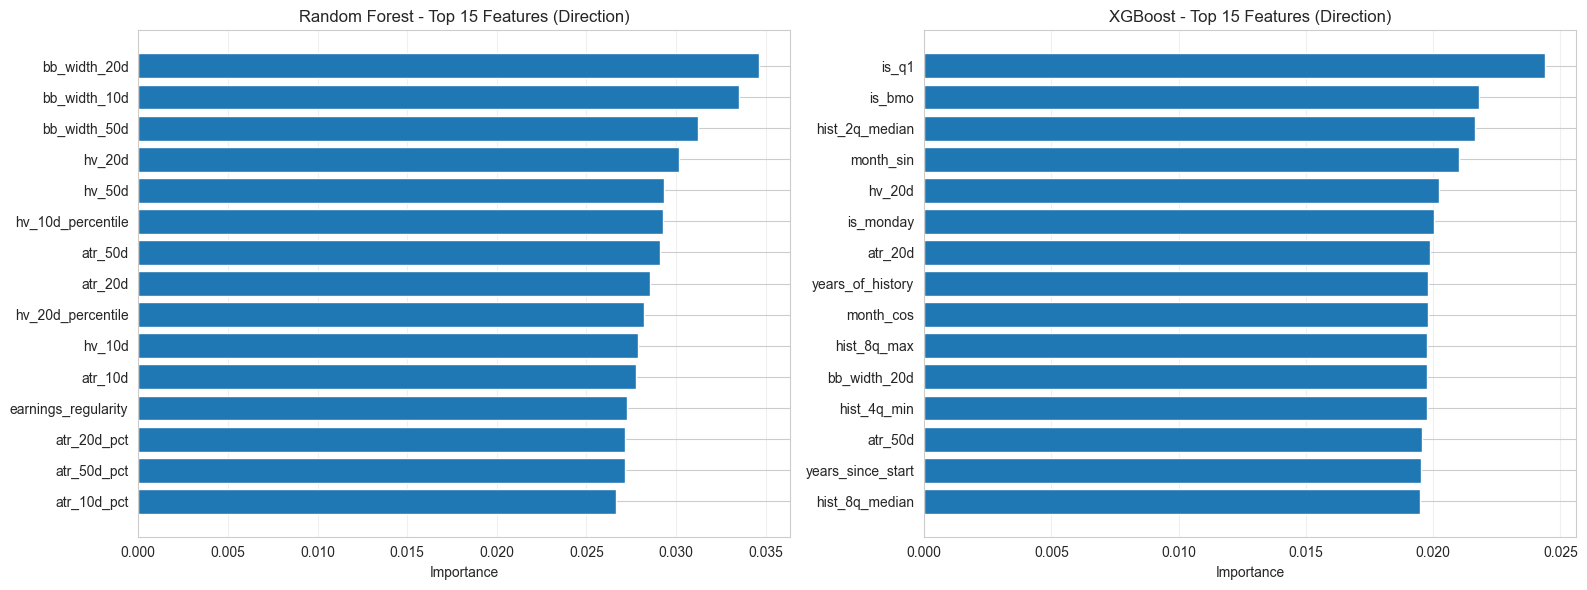

In [10]:
# Plot feature importances
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
top_rf = rf_dir_importance.head(15)
axes[0].barh(range(len(top_rf)), top_rf['importance'].values)
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'].values)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features (Direction)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
top_xgb = xgb_dir_importance.head(15)
axes[1].barh(range(len(top_xgb)), top_xgb['importance'].values)
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'].values)
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 15 Features (Direction)')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Final Performance Summary

In [11]:
print("="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

print("\n📊 DIRECTION PREDICTION (Test Set):")
print("-"*60)
print(f"  2.0 System Baseline:  {system_2_wr:.3f} (57.4%)")
print(f"  Logistic Regression:  {baseline_dir_acc:.3f} (52.8%)")
print(f"  Random Forest:        {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"  XGBoost:              {xgb_test_acc:.3f} ({xgb_test_acc*100:.1f}%)")

# Determine best model
best_acc = max(test_acc, xgb_test_acc)
best_model_name = "Random Forest" if test_acc > xgb_test_acc else "XGBoost"

print(f"\n🏆 Best Model: {best_model_name} with {best_acc:.3f} accuracy")

if best_acc > system_2_wr:
    improvement = (best_acc - system_2_wr) / system_2_wr * 100
    print(f"✅ BEATS 2.0 baseline by {improvement:.1f}% ({(best_acc - system_2_wr)*100:.1f} percentage points)")
elif best_acc >= 0.603:  # Minimum target
    print(f"✅ Achieves minimum target (60.3%)")
    gap = (system_2_wr - best_acc) * 100
    print(f"⚠️  Still {gap:.1f} percentage points below 2.0 baseline")
else:
    gap = (system_2_wr - best_acc) * 100
    print(f"⚠️  Below 2.0 baseline by {gap:.1f} percentage points")
    print(f"   Need {0.603 - best_acc:.3f} to reach minimum target (60.3%)")

print("\n📈 MAGNITUDE PREDICTION (Test Set):")
print("-"*60)
print(f"  Linear Regression: MAE={baseline_mag_mae:.3f}%, R²={baseline_mag_r2:.3f}")
print(f"  Random Forest:     MAE={test_mae:.3f}%, R²={test_r2:.3f}")
print(f"  XGBoost:           MAE={xgb_test_mae:.3f}%, R²={xgb_test_r2:.3f}")

best_r2 = max(test_r2, xgb_test_r2)
best_mag_model = "Random Forest" if test_r2 > xgb_test_r2 else "XGBoost"
print(f"\n🏆 Best Model: {best_mag_model} with R²={best_r2:.3f}")

if best_r2 > 0.30:
    print(f"✅ Exceeds target R² (0.30)")
else:
    print(f"⚠️  Below target R² by {0.30 - best_r2:.3f}")

FINAL PERFORMANCE SUMMARY

📊 DIRECTION PREDICTION (Test Set):
------------------------------------------------------------
  2.0 System Baseline:  0.574 (57.4%)
  Logistic Regression:  0.528 (52.8%)
  Random Forest:        0.540 (54.0%)
  XGBoost:              0.531 (53.1%)

🏆 Best Model: Random Forest with 0.540 accuracy
⚠️  Below 2.0 baseline by 3.4 percentage points
   Need 0.063 to reach minimum target (60.3%)

📈 MAGNITUDE PREDICTION (Test Set):
------------------------------------------------------------
  Linear Regression: MAE=2.254%, R²=0.226
  Random Forest:     MAE=2.144%, R²=0.242
  XGBoost:           MAE=2.240%, R²=0.193

🏆 Best Model: Random Forest with R²=0.242
⚠️  Below target R² by 0.058


## 7. Save Best Models

In [12]:
import joblib

# Create advanced models directory
models_dir = Path('../models/advanced')
models_dir.mkdir(parents=True, exist_ok=True)

# Save all models
joblib.dump(rf_mag, models_dir / 'random_forest_magnitude.pkl')
joblib.dump(rf_dir, models_dir / 'random_forest_direction.pkl')
joblib.dump(xgb_mag, models_dir / 'xgboost_magnitude.pkl')
joblib.dump(xgb_dir, models_dir / 'xgboost_direction.pkl')
joblib.dump(imputer, models_dir / 'imputer.pkl')

# Save feature list
with open(models_dir / 'feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols_filtered))

# Save feature importances
rf_dir_importance.to_csv(models_dir / 'rf_direction_feature_importance.csv', index=False)
xgb_dir_importance.to_csv(models_dir / 'xgb_direction_feature_importance.csv', index=False)

# Save results
results = {
    'direction': {
        'random_forest': {
            'accuracy': float(test_acc),
            'precision': float(test_prec),
            'recall': float(test_rec),
            'f1': float(test_f1)
        },
        'xgboost': {
            'accuracy': float(xgb_test_acc),
            'precision': float(xgb_test_prec),
            'recall': float(xgb_test_rec),
            'f1': float(xgb_test_f1)
        },
        'baseline_logistic': 0.528,
        'baseline_2_0': 0.574
    },
    'magnitude': {
        'random_forest': {
            'mae': float(test_mae),
            'rmse': float(np.sqrt(mean_squared_error(y_test_mag, y_pred_mag_test))),
            'r2': float(test_r2)
        },
        'xgboost': {
            'mae': float(xgb_test_mae),
            'rmse': float(np.sqrt(mean_squared_error(y_test_mag, y_pred_xgb_mag_test))),
            'r2': float(xgb_test_r2)
        },
        'baseline_linear': {
            'mae': 2.254,
            'r2': 0.226
        }
    }
}

with open(models_dir / 'advanced_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nModels and results saved to:", models_dir)
print("  - random_forest_magnitude.pkl")
print("  - random_forest_direction.pkl")
print("  - xgboost_magnitude.pkl")
print("  - xgboost_direction.pkl")
print("  - imputer.pkl")
print("  - feature_columns.txt")
print("  - rf_direction_feature_importance.csv")
print("  - xgb_direction_feature_importance.csv")
print("  - advanced_results.json")


Models and results saved to: ../models/advanced
  - random_forest_magnitude.pkl
  - random_forest_direction.pkl
  - xgboost_magnitude.pkl
  - xgboost_direction.pkl
  - imputer.pkl
  - feature_columns.txt
  - rf_direction_feature_importance.csv
  - xgb_direction_feature_importance.csv
  - advanced_results.json
